In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import constants as cs
import Dates as dates 

%reload_ext autoreload
%autoreload 2



In [17]:

def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.data_startdate: cs.data_enddate]
    return data 

data = getdata()

data



[*********************100%***********************]  2 of 2 completed


Ticker,LONN.SW,SIKA.SW
Date,,
2010-01-04,56.183731,21.728989
2010-01-05,56.219963,21.925932
2010-01-06,55.422520,22.057228
2010-01-07,56.074974,21.991579
2010-01-08,57.234905,21.860285
...,...,...
2024-07-24,522.599976,262.000000
2024-07-25,559.799988,258.500000
2024-07-26,581.000000,262.000000


In [18]:
def multi_asset_gbm(data: pd.DataFrame) -> pd.DataFrame:
    
    try:
        log_returns_list = []
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker]/data[ticker].shift(1))
            log_returns.dropna(inplace = True) # A series
            log_returns_list.append(log_returns)
        
    except Exception as e:
        raise Exception("Error at generating log return.")


    try: 
        cov_matrix = np.cov(np.array(log_returns_list))
        L = np.linalg.cholesky(cov_matrix)
        
    except Exception as e:
        raise Exception("Error at covariance matrix.")
    
    
    
  
    try: 
        sim_data = pd.DataFrame(np.zeros((cs.window_len, cs.num_ticker)), columns = cs.ticker_list)
        st_vector = data.loc[str(cs.initial_fixing_date)]
        z_list = np.random.normal(0, 1, (cs.num_ticker, cs.window_len))
        for t in range(cs.window_len):
            Z = z_list[:,t]
            for i in range(cs.num_ticker):
                LZ = np.dot(L, Z.T)
                st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
                sim_data.loc[t, cs.ticker_list[i]] = st_vector[i]

    except Exception as e:
        raise Exception("Error at simulating.")
    
    #formatting Dates 
    dates = pd.date_range(cs.initial_fixing_date, cs.final_fixing_date)
    sim_data.index = dates
    sim_data.columns = cs.sim_ticker

    return sim_data



sim_data= multi_asset_gbm(data=data)

    


C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always

<Axes: xlabel='Date'>

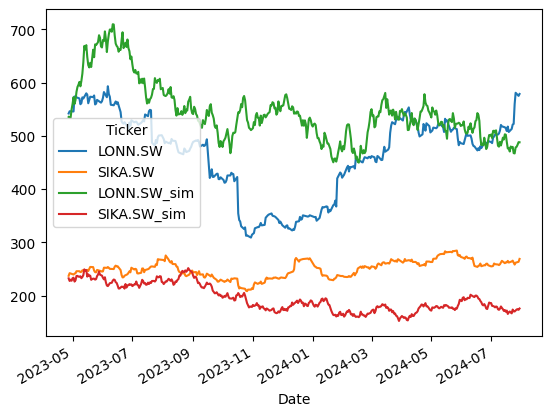

In [19]:
fig, ax = plt.subplots()
realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
realised_price.plot(ax=ax)
sim_data.plot(ax=ax)

In [20]:
def rolling_window(r: pd.DataFrame, window_len: int,  window_end: list):
   
    windows = [(end - pd.offsets.BusinessDay(n=window_len), end) for end in window_end]
    data_vectors_windows = []
    for window in windows: 
        data_in_window = r.loc[str(window[0]) : str(window[1])]
        data_vectors_windows.append(data_in_window)
    return data_vectors_windows
    


rolling_window(r = data, window_len=60, window_end = pd.bdate_range(str(cs.initial_fixing_date), str(cs.final_fixing_date)))

[Ticker         LONN.SW     SIKA.SW
 Date                              
 2023-02-02  539.161316  267.216125
 2023-02-03  544.882446  268.288910
 2023-02-06  549.222534  266.143372
 2023-02-07  545.474243  258.634033
 2023-02-08  550.011597  252.587524
 2023-02-09  542.120544  252.099899
 2023-02-10  536.004944  246.931107
 2023-02-13  537.583130  250.734558
 2023-02-14  539.358582  250.051880
 2023-02-15  544.882446  253.855331
 2023-02-16  547.447021  257.463745
 2023-02-17  546.855225  270.044312
 2023-02-20  556.127258  270.141876
 2023-02-21  552.576294  267.118622
 2023-02-22  555.535461  267.606232
 2023-02-23  556.521851  260.291931
 2023-02-24  559.283691  258.243896
 2023-02-27  561.651123  259.804291
 2023-02-28  553.168091  257.366180
 2023-03-01  551.984436  255.025620
 2023-03-02  553.562683  257.561249
 2023-03-03  559.678345  257.658783
 2023-03-06  556.324585  256.585999
 2023-03-07  544.882446  249.661789
 2023-03-08  535.413025  248.101410
 2023-03-09  533.045715  253

In [24]:
def multi_asset_gbm_n_sims(plot : bool) -> pd.DataFrame:
    sim_data_combine = pd.DataFrame()
    Z_list = np.random.normal(0,1,(cs.num_ticker, cs.window_len))
    for sim in range(cs.n_sims):
        simdata= multi_asset_gbm(data=data)
        sim_data_combine= pd. concat([sim_data_combine, simdata], axis = 1)
    
        if plot == True: 
            fig, ax = plt.subplots()
            realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
            realised_price.plot(ax=ax)
            sim_data.plot(ax=ax)
    return sim_data_combine


        
multi_asset_gbm_n_sims(plot = False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  st_vector[i] = st_vector[i] * np.exp(cs.interest_rate * cs.dt - 0.5 * cov_matrix[i][i] * cs.dt + LZ[i])
C:\Users\Admin\AppData\Local\Temp\ipykernel_31384\1365067135.py:32: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always

,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,...,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim,LONN.SW_sim,SIKA.SW_sim
2023-04-27,546.689898,236.725709,543.949506,244.168820,531.981995,230.295572,522.148409,238.416214,543.219410,245.599704,...,515.896127,230.396908,544.776399,239.375972,550.550584,235.351517,547.281844,238.637588,546.606985,238.275564
2023-04-28,562.509595,236.326976,553.834751,241.480862,546.999154,236.961442,526.673054,240.724143,563.493248,252.861739,...,503.330148,228.752401,559.480709,241.612315,564.320421,239.525151,538.532518,235.626798,542.158483,242.251325
2023-04-29,562.330336,238.443119,547.048207,245.246631,527.556463,232.800011,522.500437,233.746842,589.727297,258.402944,...,511.299314,228.601653,561.001240,238.914703,565.858336,234.609907,536.579387,235.850037,547.792419,244.483107
2023-04-30,566.720263,246.580977,547.557154,246.901870,516.864126,234.021292,516.773172,233.388623,569.346934,253.060665,...,509.304888,220.288186,572.123057,238.872559,574.366675,232.351606,546.021677,237.408186,548.925424,245.552524
2023-05-01,586.387791,247.375985,538.881159,241.420064,514.819254,231.563588,512.183351,229.378477,568.937057,259.672176,...,519.397458,225.865818,573.723343,241.379559,561.623089,231.259273,550.850190,239.461478,555.477091,245.601329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,1247.067086,346.674257,783.494136,443.919207,680.879745,549.368220,525.023886,308.382472,498.738053,465.276553,...,241.880301,221.194539,685.794299,338.729067,853.937752,207.496309,547.333104,227.497497,539.089194,171.753181
2024-07-27,1259.412125,340.225853,791.926912,447.007102,693.361043,541.189540,535.215016,314.331149,502.852512,460.057215,...,237.302350,217.266918,685.207645,332.888548,839.747933,207.953855,545.837551,228.935412,547.078209,177.019522
2024-07-28,1294.708493,345.212838,805.921554,449.263192,697.177141,546.035742,537.966799,312.898177,486.067315,453.518599,...,231.987953,211.981008,696.874733,331.327753,811.321312,205.683337,544.546697,227.191572,557.495677,178.621783
2024-07-29,1292.608501,345.986254,819.750486,451.653027,683.979668,538.779509,530.634483,315.103662,480.827878,445.003889,...,224.255269,202.310637,701.508818,328.855353,807.432375,204.048750,553.076724,229.400945,548.949819,177.173616
